# TODO Titleb


Recommendation: Use Jupyter Lab -> View -> Render Side by Side, and Right Click on Cell -> Enable Scrolling for Outputs
Recommendation: Use Jupyter Lab's left side bar to navigate between sections

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from time import time
from IPython.display import display
from importlib import reload
from core import analysis_utils as au
reload(au);

sns.set_theme(style='dark')
#plt.style.use('ggplot')
%matplotlib inline

In [2]:
CURRENT_YEAR = 2022
PATH_GENERAL_DATA = "./data/parquet/2022-09-19_general_data.parquet"
PATH_LINK_DATA = "./data/parquet/2022-09-19_link_data.parquet"
PATH_POLL_DATA = "./data/parquet/2022-09-19_poll_data.parquet"
ASPECT_WIDE = 16/9
ASPECT_NARROW = 4/3
ASPECT_SQUARE = 1
HEIGHT_STANDARD = 5

In [3]:
t1 = time()
gen_df = pd.read_parquet(PATH_GENERAL_DATA)
link_df = pd.read_parquet(PATH_LINK_DATA)
poll_df = pd.read_parquet(PATH_POLL_DATA)
t2 = time()
print(f"Loading took {round(t2 - t1, 2)} seconds.")

Loading took 8.19 seconds.


## General Data


### Overview 

Most numbers are `int`, with `float` for statistical measures. Twenty-seven (27) games are missing descriptions.

In [4]:
au.print_titled_text("Nulls and Datatypes")
gen_df.info()
au.print_spacer()
au.print_null_count(gen_df)
au.print_spacer()
au.print_titled_text("Description")
display(gen_df.describe())

NULLS AND DATATYPES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108015 entries, 0 to 108014
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       108015 non-null  int64  
 1   type                     108015 non-null  object 
 2   name                     108015 non-null  object 
 3   description              107988 non-null  object 
 4   year_published           108015 non-null  int64  
 5   players_min              108015 non-null  int64  
 6   players_max              108015 non-null  int64  
 7   playtime                 108015 non-null  int64  
 8   playtime_min             108015 non-null  int64  
 9   playtime_max             108015 non-null  int64  
 10  age_min                  108015 non-null  int64  
 11  ratings_n                108015 non-null  int64  
 12  ratings_mean             108015 non-null  float64
 13  ratings_bayes_average    108015 non-nul

,id,year_published,players_min,players_max,playtime,playtime_min,playtime_max,age_min,ratings_n,ratings_mean,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
count,108015.000000,108015.000000,108015.000000,108015.000000,1.080150e+05,108015.000000,1.080150e+05,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000,108015.0,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000,108015.000000
mean,144502.139046,1826.884525,1.992279,6.459381,1.095789e+03,41.055659,1.095789e+03,7.484081,194.979262,4.584989,1.226673,0.899536,0.0,340.307948,9.703402,9.470861,54.275573,47.778383,10.928158,0.846159
std,116161.241706,567.429968,0.846712,49.568074,2.179718e+05,556.653931,2.179718e+05,7.816799,1802.471195,2.984667,2.343914,0.882034,0.0,2675.559029,51.038205,55.819807,393.731692,327.203946,97.638728,1.101630
min,1.000000,-3500.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31041.500000,1988.000000,2.000000,2.000000,1.000000e+01,10.000000,1.000000e+01,4.000000,1.000000,1.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,129564.000000,2008.000000,2.000000,4.000000,3.000000e+01,20.000000,3.000000e+01,8.000000,3.000000,5.583000,0.000000,1.000000,0.0,8.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
75%,247799.500000,2016.000000,2.000000,6.000000,6.000000e+01,45.000000,6.000000e+01,12.000000,21.000000,6.769000,0.000000,1.533850,0.0,57.000000,2.000000,2.000000,9.000000,10.000000,2.000000,1.667000
max,362381.000000,2026.000000,50.000000,11299.000000,6.307200e+07,157680.000000,6.307200e+07,2017.000000,113935.000000,10.000000,8.469000,4.500000,0.0,178195.000000,2741.000000,1960.000000,20430.000000,20125.000000,7854.000000,5.000000


In [5]:
null_desc = gen_df[gen_df['description'].isnull()]
display(null_desc)
au.print_spacer()
au.print_titled_text('links')
au.display_id_link(null_desc['id'].iloc[0])

,id,type,name,description,year_published,players_min,players_max,playtime,playtime_min,playtime_max,...,ratings_bayes_average,ratings_stddev,ratings_median,ratings_owned,ratings_trading,ratings_wanting,ratings_wishing,ratings_comments_n,ratings_weights_n,ratings_weights_average
385,224083,boardgame,Trono Oscuro,None,2017,2,5,120,60,120,...,0.000,0.0000,0.0,3,0,0,1,1,0,0.0
7724,243593,boardgame,Bastille: Fallen Kingdoms,None,2017,3,6,1400,60,1400,...,0.000,0.0000,0.0,0,0,0,0,0,0,0.0
13398,146535,boardgame,Math Battleship Game,None,2013,1,0,30,30,30,...,0.000,0.0000,0.0,0,0,0,1,0,0,0.0
14112,320241,boardgame,Electric Orchard,None,2021,2,4,60,30,60,...,0.000,0.0000,0.0,0,0,1,2,0,0,0.0
19282,174579,boardgame,Ex-Machina,None,2015,2,4,10,6,10,...,0.000,0.0000,0.0,3,0,0,1,0,0,0.0
23952,261574,boardgame,Black Hole,None,2018,1,4,40,20,40,...,0.000,0.0000,0.0,2,0,1,0,1,0,0.0
24162,180869,boardgame,Off with His Straw Head,None,2015,3,5,10,10,10,...,0.000,0.0000,0.0,4,0,0,0,0,0,0.0
27085,112878,boardgame,Ammo Domini: Fight for Europe to the Last Bullet,None,2012,2,5,0,0,0,...,0.000,0.0000,0.0,0,0,1,12,0,0,0.0
28344,174577,boardgame,Into the Rabbit Hole,None,2015,2,5,15,10,15,...,0.000,0.0000,0.0,5,0,0,0,0,0,0.0
28357,170984,boardgame,Timeline: Sports et Loisirs,None,2014,2,8,15,15,15,...,5.533,1.6166,0.0,178,2,7,32,10,2,1.0





LINKS
=====


#### Duplication check

In [6]:
au.print_titled_text('Duplicated rows')
gen_df.duplicated().sum()

DUPLICATED ROWS


0

### Individual Variable Overview

In this section, we take a look at each variable outputting summary plots as needed.

#### `id`

Each boardgame has a unique id associated with it.

In [7]:
gen_df.id.describe()

count    108015.000000
mean     144502.139046
std      116161.241706
min           1.000000
25%       31041.500000
50%      129564.000000
75%      247799.500000
max      362381.000000
Name: id, dtype: float64

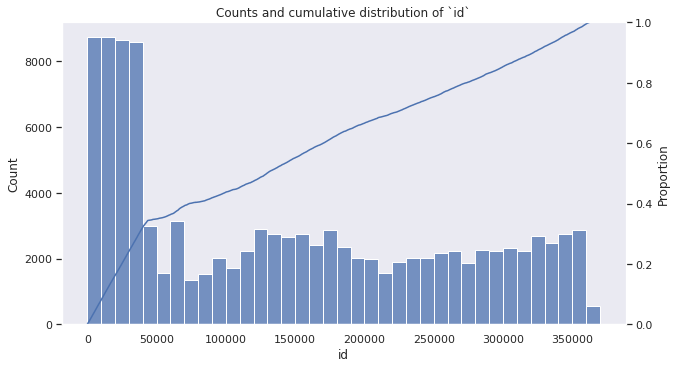

In [8]:
g = sns.displot(data=gen_df,
            x='id',
            binwidth=10_000,
            height=HEIGHT_STANDARD,
            aspect=ASPECT_WIDE);

ax2 = g.ax.twinx()

sns.ecdfplot(ax=ax2,
             data=gen_df,
             x='id'
            );

g.set(title='Counts and cumulative distribution of `id`');




In the histogram above, since the bin size is 10,000, bins that don't reach that must have "missing" ids (e.g. sequential ids could be 5, 10, 12, missing the in between numbers).

The plot below sorts ids into sequence and plots the difference between each id, where a difference of 1 indicates no missing ids between two sequential ids.

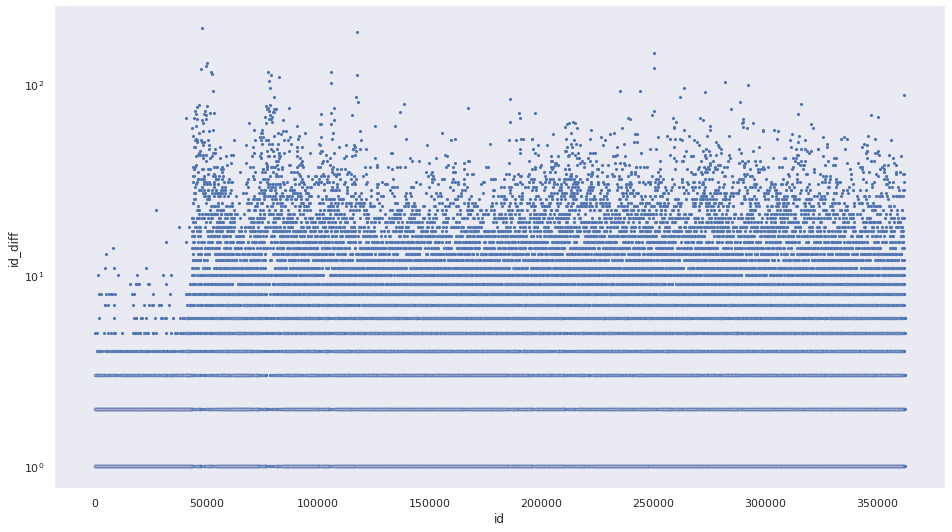

In [9]:
# Compute difference between an id and its preceding id.
# I.e., a diff > 1 indicates a missing id number
def make_id_diffs(df: pd.DataFrame,
                  id_key: str = 'id',
                  diffs_key: str = 'id_diff',
                  name_key: str = 'name') -> pd.DataFrame:
    ids_sorted = df[[id_key, name_key]].sort_values(by=id_key)
    ids_diff = ids_sorted[id_key].diff()
    out = pd.concat([ids_sorted, ids_diff],
                    axis=1,
                    ignore_index=True)
    out.columns = [id_key, name_key, diffs_key]
    return out


id_diffs = make_id_diffs(gen_df)
g = sns.relplot(data=id_diffs,
            x='id',
            y='id_diff',
            kind='scatter',
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_WIDE,
            linewidth=0.05,
            s=10,
            );
g.set(yscale='log');



A cursory sampling of the missing ids suggests that missing ids < ~50000 are from board game expansions (e.g.24714), whereas those > ~ 50000 include various other objects including tabletop rpg ruleset books (e.g. 337080) and video games (e.g. 240813). Missings ids also include ids that are no longer assigned to any item (e.g. 20723), redirects (e.g. 9517 redirects to 2065).

In [99]:
# Missing ids are where 
missing_ids = set([i for i in range(1, gen_df['id'].max())]) - set(gen_df['id'])
assert len(missing_ids) == (gen_df['id'].max() - gen_df.shape[0])

random.seed(7)
au.print_titled_text("Early ids")
for i in random.sample([e for e in missing_ids if e < 40000], 5):
    au.display_id_link(i)
au.print_titled_text("Later ids")
for i in random.sample([e for e in missing_ids if e > 60000], 5):
    au.display_id_link(i)

EARLY IDS


LATER IDS


#### `type`

In [100]:
gen_df['type'].value_counts()

boardgame    108015
Name: type, dtype: int64

#### `year_published`

In [ ]:
g = sns.displot(data=gen_df,
                x='year_published',
                binwidth=100,
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE,);

g.set(title="year_published histogram");

g = sns.displot(data=gen_df,
                x='year_published',
                binwidth=100,
                log_scale=(False, True),
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE,);

g.set(title="year_published histogram (log scale y)");

In [ ]:
g = sns.displot(data=gen_df.query("year_published > 1900"),
                x='year_published',
                binwidth=1,
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE,);

g.set(title="year_published > 1900 histogram");

In [ ]:
(gen_df['year_published'] == 0).sum()

In [ ]:
gen_df[(gen_df['year_published'] == 0)].head()
au.display_id_links_from_df(
    gen_df[(gen_df['year_published'] == 0)].head())

In [ ]:
sns.jointplot(data=gen_df, x='id', y='year_published');

#### `players_min` and `players_max`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='players_min',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
);

g.set(title="players_min histogram");

g = sns.displot(
        data=gen_df,
        x='players_min',
        log_scale=(False, True),
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
);

g.set(title="players_min histogram log scale");

#### `playtime`, `playtime_min`, and `playtime_max`

In [ ]:
g = sns.displot(
        data=gen_df.query("playtime <= 600"),
        x='playtime',
        binwidth=5,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
        linewidth=0.03,
)

g.set(title="playtime <= 10 hours histogram");

g = sns.displot(
        data=gen_df.query("playtime > 600"),
        x='playtime',
        binwidth=1000,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
        linewidth=0.03,
)

g.set(title="playtime > 10 hours histogram");

In [ ]:
g = sns.displot(
        data=gen_df,
        x='playtime_min',
        binwidth=1_000_000,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
)

g.set(title="playtime_min histogram");

In [ ]:
g = sns.displot(
            data=gen_df,
            x='playtime_max',
            binwidth=1_000_000,
            height=HEIGHT_STANDARD,
            aspect=ASPECT_WIDE,
)

g.set(title="playtime_max histogram");

In [ ]:
gen_df[(gen_df['playtime']> 1200)].describe()

In [ ]:
au.display_id_link(317582)

In [ ]:
display(gen_df[gen_df['playtime'] == gen_df['playtime'].max()])
au.display_id_link(351507)


In [ ]:
def plot_playtimes(df: pd.DataFrame) -> None:
    f, ax = plt.subplots(figsize=(5,5))
    # should be... x is time, y is count, based on sort of playtime
    playtimes = df[['playtime',
                    'playtime_min',
                    'playtime_max']].reset_index()
    ax.plot(df['playtime'], df.index)
    
plot_playtimes(gen_df)
    
    

#### `age_min`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='age_min',
        binwidth=10,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
        log_scale=(False, True)
);

g.set(title="age_min histogram");

x_max = 200
g = sns.displot(
        data=gen_df.query(f"age_min < {x_max}"),
        x='age_min',
        binwidth=1,
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE,
        log_scale=(False, True)
)

g.set(title=f"age_min histogram for age_min < {x_max}");


#### `ratings_n`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_n',
        binwidth=1000,
        log_scale=(False, True),
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_n histogram');

#### `ratings_mean`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_mean',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_mean histogram')

#### `ratings_bayes_average`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_bayes_average',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_bayes_average histogram')

#### `ratings_stddev`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_stddev',
        heighHEIGHT_STANDARDHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_stddev histogram')

#### `ratings_median`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_median',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_median histogram')

#### `ratings_owned`

In [ ]:
gen_df.sort_values('ratings_owned', ascending=False).head(10)

In [ ]:
g = sns.displot(data=gen_df,
                x='ratings_owned',
                kind='hist',
                binwidth=1000,
                height=HEIGHT_STANDARD,
                aspect=ASPECT_WIDE);

g.set(yscale='log');

In [ ]:
gen_df['ratings_owned'].describe()

In [ ]:
au.print_titled_text("Proportion of games with no owners")
(gen_df['ratings_owned'] == 0).mean().round(3)

#### `ratings_trading`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_trading',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_trading histogram')

#### `ratings_wanting`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_wanting',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_wanting histogram')

#### `ratings_wishing`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_wishing',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_wishing histogram')

#### `ratings_comments_n`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_comments_n',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_comments_n histogram')

#### `ratings_weights_n`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_weights_n',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_weights_n histogram')

#### `ratings_weights_average`

In [ ]:
g = sns.displot(
        data=gen_df,
        x='ratings_weights_average',
        height=HEIGHT_STANDARD,
        aspect=ASPECT_WIDE
);

g.set(title='ratings_weights_average histogram')

### Part 2

In [ ]:
sns.relplot(data=gen_df,
            x='ratings_n',
            y='ratings_mean',
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_NARROW,
           );

In [ ]:
sns.relplot(data=gen_df.query("ratings_n > 21"),
            x='ratings_n',
            y='ratings_mean',
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_NARROW,
            linewidth=0.1,
            alpha=0.2
           );

In [ ]:
gen_df.query("ratings_bayes_average == 0")['ratings_n'].describe()

In [ ]:
sns.relplot(data=gen_df,
            x='ratings_bayes_average',
            y='ratings_mean',
            hue=gen_df['ratings_n'] <= 29,
            height=HEIGHT_STANDARD*1.5,
            aspect=ASPECT_NARROW,
            linewidth=0.1,
            alpha=0.2
           );

In [ ]:
data = gen_df.query("ratings_bayes_average > 0")
log_ratings_n = np.log10(data['ratings_n'])
log_ratings_n.name = "log10_ratings_n"
f, ax = plt.subplots(
    1,
    1,
    figsize=(HEIGHT_STANDARD*2, HEIGHT_STANDARD*2))
sns.scatterplot(
        ax=ax,
        data=data,
        x='ratings_bayes_average',
        y='ratings_mean',
        hue=log_ratings_n,
        linewidth=0.1,
        alpha=0.2
        );

ax.set_xlim([0,10])
ax.set_ylim([0,10])
# x=y
ax.plot([0,10],[0,10],
        alpha=0.08,
        linewidth=3,
        color='black');


In [ ]:
# TODO reverse engineer fuzzing algo

In [ ]:
gen_df['ratings_n'].describe()

### Link data

In [86]:
link_df.head()

,boardgame_id,type,value,link_id,inbound
0,101769,boardgamecategory,Dice,1017,None
1,101769,boardgamecategory,Economic,1021,None
2,101769,boardgamemechanic,Dice Rolling,2072,None
3,101769,boardgamemechanic,Roll / Spin and Move,2035,None
4,101769,boardgamedesigner,Wolfgang Kramer,7,None


In [96]:
link_df.shape

(1053398, 5)

In [95]:
link_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053398 entries, 0 to 1053397
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   boardgame_id  1053398 non-null  int64 
 1   type          1053398 non-null  object
 2   value         1053398 non-null  object
 3   link_id       1053398 non-null  int64 
 4   inbound       8986 non-null     object
dtypes: int64(2), object(3)
memory usage: 40.2+ MB


In [97]:
link_df.describe()

,boardgame_id,link_id
count,1.053398e+06,1.053398e+06
mean,1.505440e+05,2.687520e+04
std,1.180027e+05,5.926709e+04
min,1.000000e+00,1.000000e+00
25%,3.091325e+04,1.041000e+03
50%,1.433050e+05,2.072000e+03
75%,2.570070e+05,2.218400e+04
max,3.623810e+05,3.702940e+05


In [88]:
link_df.groupby('type').nunique()

,boardgame_id,value,link_id,inbound
type,,,,
boardgameartist,44813,23151,23187,0
boardgamecategory,105979,84,84,0
boardgamecompilation,2350,3276,3304,1
boardgamedesigner,91199,33281,33319,0
boardgameexpansion,8085,28634,28675,1
boardgamefamily,73599,4612,4612,0
boardgameimplementation,9333,9358,9542,1
boardgameintegration,3849,3978,3985,0
boardgamemechanic,91722,188,188,0


In [94]:
display(link_df[link_df['inbound'].notna()].shape)
link_df[link_df['inbound'].notna()].head()


(8986, 5)

,boardgame_id,type,value,link_id,inbound
55,304743,boardgameimplementation,Absolute Dice,304740,true
147,257273,boardgameimplementation,That's Life!,17240,true
491,342924,boardgameimplementation,Timeline: Inventions,85256,true
1014,217470,boardgameimplementation,Qwinto,183006,true
1066,214026,boardgamecompilation,Cheaters' Chili,244805,true


## Part 3 When is the golden age of board games